### Part1: Import Libraries and Load Data

In [1]:
#Import Necessary Libraries

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import the Files

df_load = pd.read_csv('loan.csv', low_memory=False)

In [3]:
#Display 100 columns to make the dataframe readable

pd.set_option('display.max_columns', 100)

#Select only the necessary columns
#Since we only want to find out whether the customer will default or not, we will have to drop all data pertaining to Current as it could skew our results
df = df_load[['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 
              'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 
              'purpose', 'addr_state', 'dti', 'open_acc', 'pub_rec', 'total_acc']]

### Part 2: Data Preperation and Clean Up, Creation of Data-driven variables

In [4]:
#Check Datatypes of certain Columns

print('Loan Amount Data Type: ' + str(df['loan_amnt'].dtype))
print('Funded Amount Data Type: ' + str(df['funded_amnt'].dtype))
print('Funded Amount by Investors Data Type: ' + str(df['funded_amnt_inv'].dtype))
print('Term Data Type: ' + str(df['term'].dtype))
print('Interest Rate Data Type: ' + str(df['int_rate'].dtype))
print('Grade Data Type: ' + str(df['grade'].dtype))
print('Sub Grade Data Type: ' + str(df['sub_grade'].dtype))
print('Employment Length Data Type: ' + str(df['emp_length'].dtype))
print('Home Ownership Data Type: ' + str(df['home_ownership'].dtype))
print('Annual Income Data Type: ' + str(df['annual_inc'].dtype))
print('purpose Data Type: ' + str(df['purpose'].dtype))
print('addr_state Data Type: ' + str(df['addr_state'].dtype))
print('dti Data Type: ' + str(df['dti'].dtype))
print('open_acc Data Type: ' + str(df['open_acc'].dtype))
print('total_acc Data Type: ' + str(df['total_acc'].dtype))

Loan Amount Data Type: int64
Funded Amount Data Type: int64
Funded Amount by Investors Data Type: float64
Term Data Type: object
Interest Rate Data Type: object
Grade Data Type: object
Sub Grade Data Type: object
Employment Length Data Type: object
Home Ownership Data Type: object
Annual Income Data Type: float64
purpose Data Type: object
addr_state Data Type: object
dti Data Type: float64
open_acc Data Type: int64
total_acc Data Type: int64


In [5]:
#Convert interest rate to float for better analysis

df['int_rate'] = df['int_rate'].str.rstrip('%')
df['int_rate'] = pd.to_numeric(df['int_rate'])

In [6]:
#Take the income values up to 95th percentile as higher than that are outliers and will skew the analysis

print(df['annual_inc'].quantile(0.95))
top95 = df['annual_inc'].quantile(0.95)
df = df[df['annual_inc'] <= top95]

142000.0


In [7]:
#Rename FUlly Paid to Non-Defaulter and Charged off to Defaulter for better reading
df['loan_status'].loc[df['loan_status'] == 'Fully Paid'] = 'Non-Defaulter'
df['loan_status'].loc[df['loan_status'] == 'Charged Off'] = 'Defaulter'

#Remove all the current customers as they do not give us any insight on the whether the customer defaults or not
df = df[df['loan_status'] != 'Current']

In [8]:
#Categorize the Employment Length
_1to5years = ['1 year',"2 years", "3 years", "4 years", "5 years"]
_6to9years = ["6 years", "7 years", "8 years", "9 years"]

df['emp_length'].loc[df['emp_length'].isin(_1to5years)] = '1 to 5 years'
df['emp_length'].loc[df['emp_length'].isin(_6to9years)] = '6 to 9 years'

<AxesSubplot:>

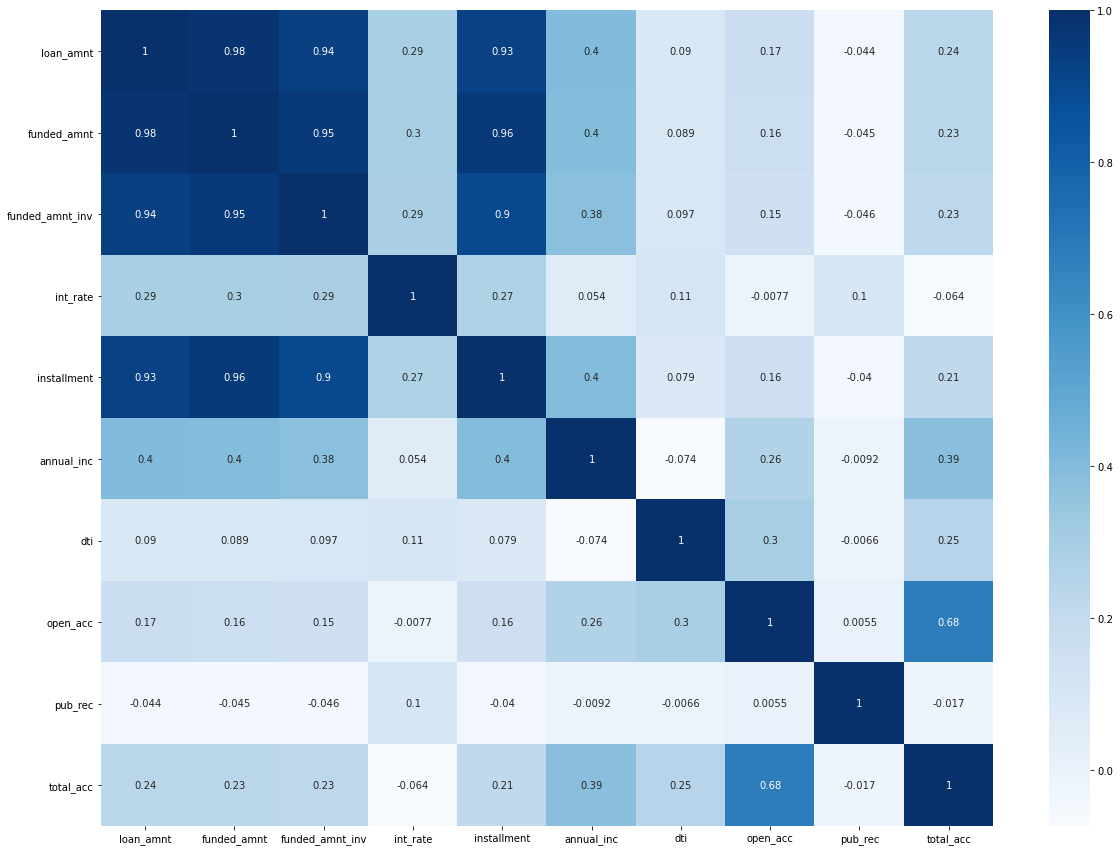

In [9]:
#Plot the corelation matrix to get some insights
plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), cmap="Blues", annot=True)

In [10]:
#From the above Heatmap we can see that loan_amt, funded_amt, funded_amt_inv and installment are highly corellated.
#From this we can infer that any analysis made on these variable will give the same results.
#Therefore we can use just one variable for analysis and drop the remaining.
#We will drop funded_amt, funded_amt_inv and installment because funded_amt and funded_amt_inv are very similar to loan_amt, and installments are mostly equal to a fraction of loan_amt

df.drop(['funded_amnt', 'funded_amnt_inv', 'installment'], axis=1, inplace=True)

In [11]:
#Categorize the Term into Short Term and Long Term

def term_categorize(x):
    if x == " 36 months":
        return "Short Term"
    elif x == " 60 months":
        return "Long Term"
    else:
        return

    
df['term_categorized'] = df['term'].apply(lambda x: term_categorize(x))

In [12]:
#Categorize the Loan Amount into LOW, MID and HIGH

def loanamount_categorize(x):
    if x <= 12000:                #32000 is median income
        return "LOW"
    elif 12000 < x <= 24000:
        return "MID"
    elif x > 24000:
        return "HIGH"
    
df['loan_amnt_categorized'] = df['loan_amnt'].apply(lambda x: loanamount_categorize(x))

In [13]:
#Categorize the interest Rate into LOW, MID LOW, MID HIGH, HIGH

def intrate_categorize(x):
    if x <= 10:                #32000 is median income
        return "LOW"
    elif 10 < x <= 15:
        return "MID LOW"
    elif 15 < x <= 20:
        return "MID HIGH"
    elif x > 20:
        return "HIGH"
    
df['int_rate_categorized'] = df['int_rate'].apply(lambda x: intrate_categorize(x))

In [14]:
#Categorize the dti into LOW, MID and HIGH

def dti_categorize(x):
    if x <= 10:                #32000 is median income
        return "LOW"
    elif 10 < x <= 20:
        return "MID"
    elif x > 20:
        return "HIGH"
    
df['dti_categorized'] = df['dti'].apply(lambda x: dti_categorize(x))

In [15]:
#Categorize the income
def income_categorize(x):
    if x < 32000:                #32000 is median income
        return "LOW"
    elif 32000 < x < 80000:
        return "Above Average"
    elif x > 80000:
        return "HIGH"
    
df['annual_inc_categorized'] = df['annual_inc'].apply(lambda x: income_categorize(x))

### Part 3: Univariate Analysis and Plotting

[Text(0.5, 0, 'Loan Amount'), Text(0, 0.5, 'Percentage')]

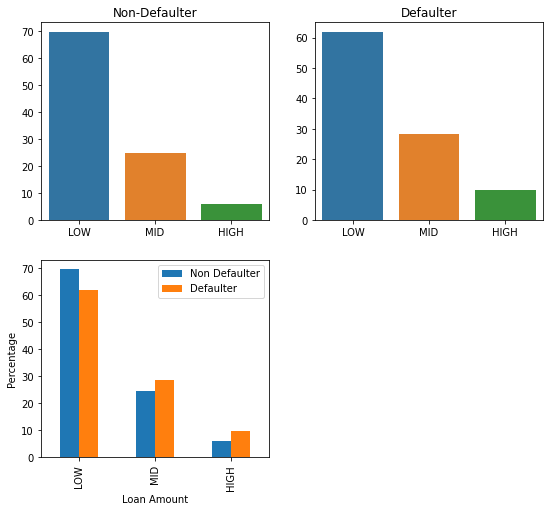

In [16]:
#Plotting Loan_amt to get insights on how this variable affects Default

d1 = (df[df['loan_status'] == 'Non-Defaulter']['loan_amnt_categorized'].value_counts(normalize=True)*100).to_dict()
d2 = (df[df['loan_status'] == 'Defaulter']['loan_amnt_categorized'].value_counts(normalize=True)*100).to_dict()

df_plot = pd.DataFrame.from_dict(d1, orient='index')
df_plot[1] = df_plot.index.map(d2)
df_plot['label'] = df_plot.index
df_plot.rename(columns={0:'Non Defaulter', 1:'Defaulter'}, inplace =True)

fig = plt.figure()

ax = fig.add_subplot(2, 2, 1)
sns.barplot(x=list(d1.keys()), y=list(d1.values()), ax=ax).set_title('Non-Defaulter')
ax = fig.add_subplot(2, 2, 2)
sns.barplot(x=list(d2.keys()), y=list(d2.values()), ax=ax).set_title('Defaulter')
ax = fig.add_subplot(2, 2, 3)
df_plot.plot(x='label', y=['Non Defaulter', 'Defaulter'], kind="bar",figsize=(9,8), ax=ax)
ax.set(xlabel='Loan Amount', ylabel='Percentage')

#plt.savefig('Loan Amount.png')

#Here we can see that as the loan amount increases, the likelyhood of default increases

[Text(0.5, 0, 'common xlabel'), Text(0, 0.5, 'Percentage')]

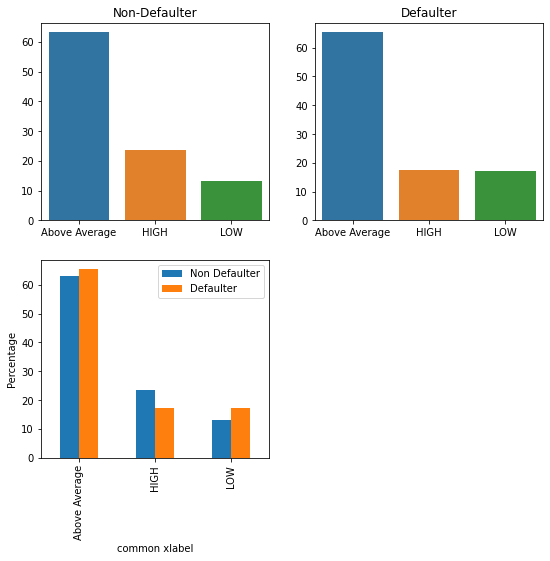

In [17]:
#Plotting annual_inc to get insights on how this variable affects Default

d1 = (df[df['loan_status'] == 'Non-Defaulter']['annual_inc_categorized'].value_counts(normalize=True)*100).to_dict()
d2 = (df[df['loan_status'] == 'Defaulter']['annual_inc_categorized'].value_counts(normalize=True)*100).to_dict()

df_plot = pd.DataFrame.from_dict(d1, orient='index')
df_plot[1] = df_plot.index.map(d2)
df_plot['label'] = df_plot.index
df_plot.rename(columns={0:'Non Defaulter', 1:'Defaulter'}, inplace =True)

fig = plt.figure()

ax = fig.add_subplot(2, 2, 1)
sns.barplot(x=list(d1.keys()), y=list(d1.values()), ax=ax).set_title('Non-Defaulter')
ax = fig.add_subplot(2, 2, 2)
sns.barplot(x=list(d2.keys()), y=list(d2.values()), ax=ax).set_title('Defaulter')
ax = fig.add_subplot(2, 2, 3)
df_plot.plot(x='label', y=['Non Defaulter', 'Defaulter'], kind="bar",figsize=(9,8), ax=ax)
ax.set(xlabel='common xlabel', ylabel='Percentage')

#plt.savefig('Annual Income.png')

#Here we can see that as the loan amount increases, the likelyhood of default decreases. 
#For low income, the likely hood o fdefault is very high, but for Above average income, the likeylyhood of default is slightly lower
#And for high income, the likelyhood of default is significantly lower

[Text(0.5, 0, 'Term'), Text(0, 0.5, 'Percentage')]

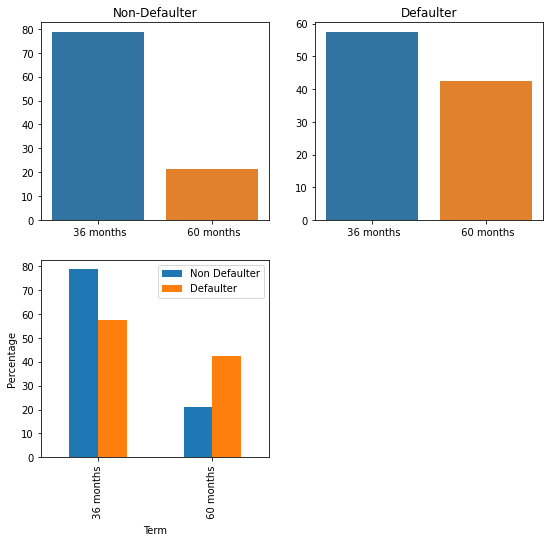

In [18]:
#Plotting term to get insights on how this variable affects Default

d1 = (df[df['loan_status'] == 'Non-Defaulter']['term'].value_counts(normalize=True)*100).to_dict()
d2 = (df[df['loan_status'] == 'Defaulter']['term'].value_counts(normalize=True)*100).to_dict()

df_plot = pd.DataFrame.from_dict(d1, orient='index')
df_plot[1] = df_plot.index.map(d2)
df_plot['label'] = df_plot.index
df_plot.rename(columns={0:'Non Defaulter', 1:'Defaulter'}, inplace =True)

fig = plt.figure()

ax = fig.add_subplot(2, 2, 1)
sns.barplot(x=list(d1.keys()), y=list(d1.values()), ax=ax).set_title('Non-Defaulter')
ax = fig.add_subplot(2, 2, 2)
sns.barplot(x=list(d2.keys()), y=list(d2.values()), ax=ax).set_title('Defaulter')
ax = fig.add_subplot(2, 2, 3)
df_plot.plot(x='label', y=['Non Defaulter', 'Defaulter'], kind="bar",figsize=(9,8), ax=ax)
ax.set(xlabel='Term', ylabel='Percentage')

#plt.savefig('Term.png')

#Here we can see that as the time(term) increases, the likelyhood of default increases

[Text(0.5, 0, 'Employment Length'), Text(0, 0.5, 'Percentage')]

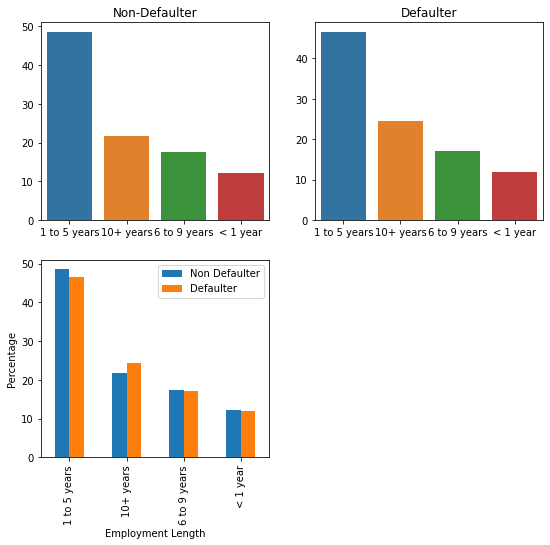

In [19]:
#Plotting emp_length to get insights on how this variable affects Default

d1 = (df[df['loan_status'] == 'Non-Defaulter']['emp_length'].value_counts(normalize=True)*100).to_dict()
d2 = (df[df['loan_status'] == 'Defaulter']['emp_length'].value_counts(normalize=True)*100).to_dict()

df_plot = pd.DataFrame.from_dict(d1, orient='index')
df_plot[1] = df_plot.index.map(d2)
df_plot['label'] = df_plot.index
df_plot.rename(columns={0:'Non Defaulter', 1:'Defaulter'}, inplace =True)

fig = plt.figure()

ax = fig.add_subplot(2, 2, 1)
sns.barplot(x=list(d1.keys()), y=list(d1.values()), ax=ax).set_title('Non-Defaulter')
ax = fig.add_subplot(2, 2, 2)
sns.barplot(x=list(d2.keys()), y=list(d2.values()), ax=ax).set_title('Defaulter')
ax = fig.add_subplot(2, 2, 3)
df_plot.plot(x='label', y=['Non Defaulter', 'Defaulter'], kind="bar",figsize=(9,8), ax=ax)
ax.set(xlabel='Employment Length', ylabel='Percentage')

#plt.savefig('Employment Length.png')

#We see an interesting observation here. People who have been employed for less than 10 years are less likely to default that those who have been employed for over 10 years

[Text(0.5, 0, 'Grade'), Text(0, 0.5, 'Percentage')]

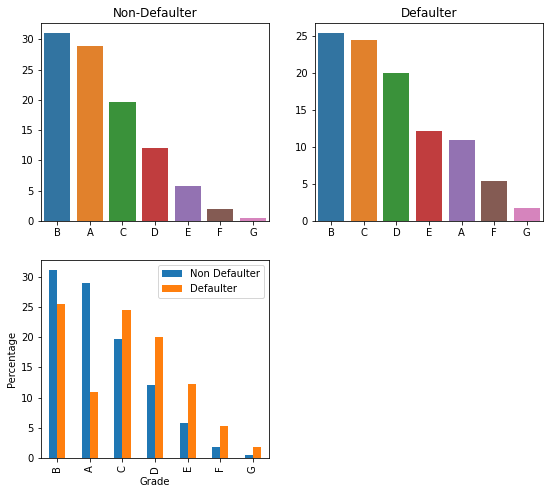

In [20]:
#Plotting grade to get insights on how this variable affects Default

d1 = (df[df['loan_status'] == 'Non-Defaulter']['grade'].value_counts(normalize=True)*100).to_dict()
d2 = (df[df['loan_status'] == 'Defaulter']['grade'].value_counts(normalize=True)*100).to_dict()

df_plot = pd.DataFrame.from_dict(d1, orient='index')
df_plot[1] = df_plot.index.map(d2)
df_plot['label'] = df_plot.index
df_plot.rename(columns={0:'Non Defaulter', 1:'Defaulter'}, inplace =True)

fig = plt.figure()

ax = fig.add_subplot(2, 2, 1)
sns.barplot(x=list(d1.keys()), y=list(d1.values()), ax=ax).set_title('Non-Defaulter')
ax = fig.add_subplot(2, 2, 2)
sns.barplot(x=list(d2.keys()), y=list(d2.values()), ax=ax).set_title('Defaulter')
ax = fig.add_subplot(2, 2, 3)
df_plot.plot(x='label', y=['Non Defaulter', 'Defaulter'], kind="bar",figsize=(9,8), ax=ax)
ax.set(xlabel='Grade', ylabel='Percentage')

#plt.savefig('Grade.png')

#As the grade goes up, the likely hood of default increases greately. Here, Grade A, B are the only once where the chances of default is lower than the non-default.

[Text(0.5, 0, 'Verification Status'), Text(0, 0.5, 'Percentage')]

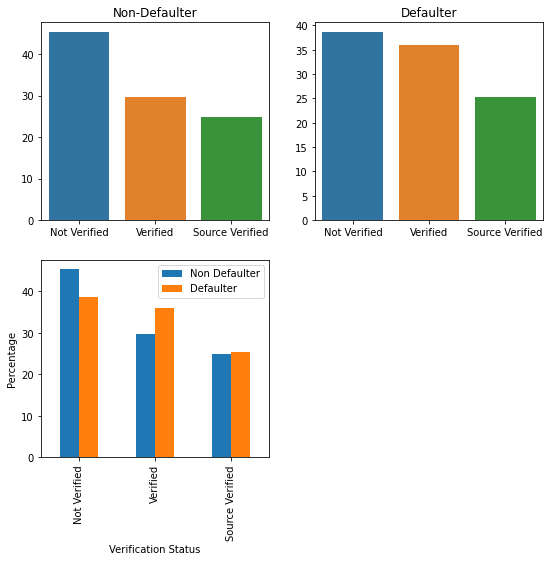

In [21]:
#Plotting verification Status to get insights on how this variable affects Default

d1 = (df[df['loan_status'] == 'Non-Defaulter']['verification_status'].value_counts(normalize=True)*100).to_dict()
d2 = (df[df['loan_status'] == 'Defaulter']['verification_status'].value_counts(normalize=True)*100).to_dict()

df_plot = pd.DataFrame.from_dict(d1, orient='index')
df_plot[1] = df_plot.index.map(d2)
df_plot['label'] = df_plot.index
df_plot.rename(columns={0:'Non Defaulter', 1:'Defaulter'}, inplace =True)

fig = plt.figure()

ax = fig.add_subplot(2, 2, 1)
sns.barplot(x=list(d1.keys()), y=list(d1.values()), ax=ax).set_title('Non-Defaulter')
ax = fig.add_subplot(2, 2, 2)
sns.barplot(x=list(d2.keys()), y=list(d2.values()), ax=ax).set_title('Defaulter')
ax = fig.add_subplot(2, 2, 3)
df_plot.plot(x='label', y=['Non Defaulter', 'Defaulter'], kind="bar",figsize=(9,8), ax=ax)
ax.set(xlabel='Verification Status', ylabel='Percentage')

#plt.savefig('Verification Status.png')

#Income sources that are not verified are less likely to default. The fact that the default rate of Verified income is higher could be due to faulty verification as the source verified does not have a significant default rate

[Text(0.5, 0, 'Interest Rate'), Text(0, 0.5, 'Percentage')]

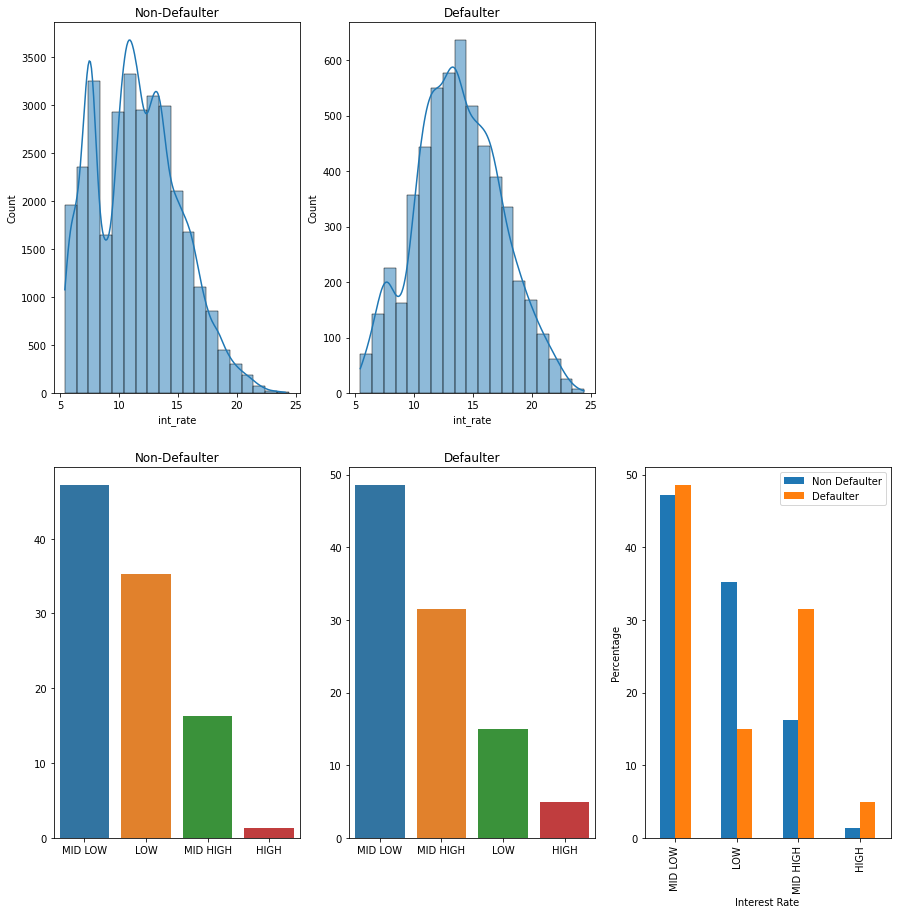

In [22]:
#Plotting Interest Rate to get insights on how this variable affects Default

fig = plt.figure()

ax = fig.add_subplot(2, 3, 1)
sns.histplot(df[df['loan_status'] == 'Non-Defaulter']['int_rate'], binwidth=1, kde=True, ax=ax).set_title('Non-Defaulter')
ax = fig.add_subplot(2, 3, 2)
sns.histplot(df[df['loan_status'] == 'Defaulter']['int_rate'], binwidth=1, kde=True, ax=ax).set_title('Defaulter')

d1 = (df[df['loan_status'] == 'Non-Defaulter']['int_rate_categorized'].value_counts(normalize=True)*100).to_dict()
d2 = (df[df['loan_status'] == 'Defaulter']['int_rate_categorized'].value_counts(normalize=True)*100).to_dict()

df_plot = pd.DataFrame.from_dict(d1, orient='index')
df_plot[1] = df_plot.index.map(d2)
df_plot['label'] = df_plot.index
df_plot.rename(columns={0:'Non Defaulter', 1:'Defaulter'}, inplace =True)

ax = fig.add_subplot(2, 3, 4)
sns.barplot(x=list(d1.keys()), y=list(d1.values()), ax=ax).set_title('Non-Defaulter')
ax = fig.add_subplot(2, 3, 5)
sns.barplot(x=list(d2.keys()), y=list(d2.values()), ax=ax).set_title('Defaulter')
ax = fig.add_subplot(2, 3, 6)
df_plot.plot(x='label', y=['Non Defaulter', 'Defaulter'], kind="bar",figsize=(15,15), ax=ax)
ax.set(xlabel='Interest Rate', ylabel='Percentage')

#plt.savefig('Interest Rate.png')

#Here we can clearly see that as the interest rate increases, the chances of default increase dramatically.

[Text(0.5, 0, 'DTI'), Text(0, 0.5, 'Percentage')]

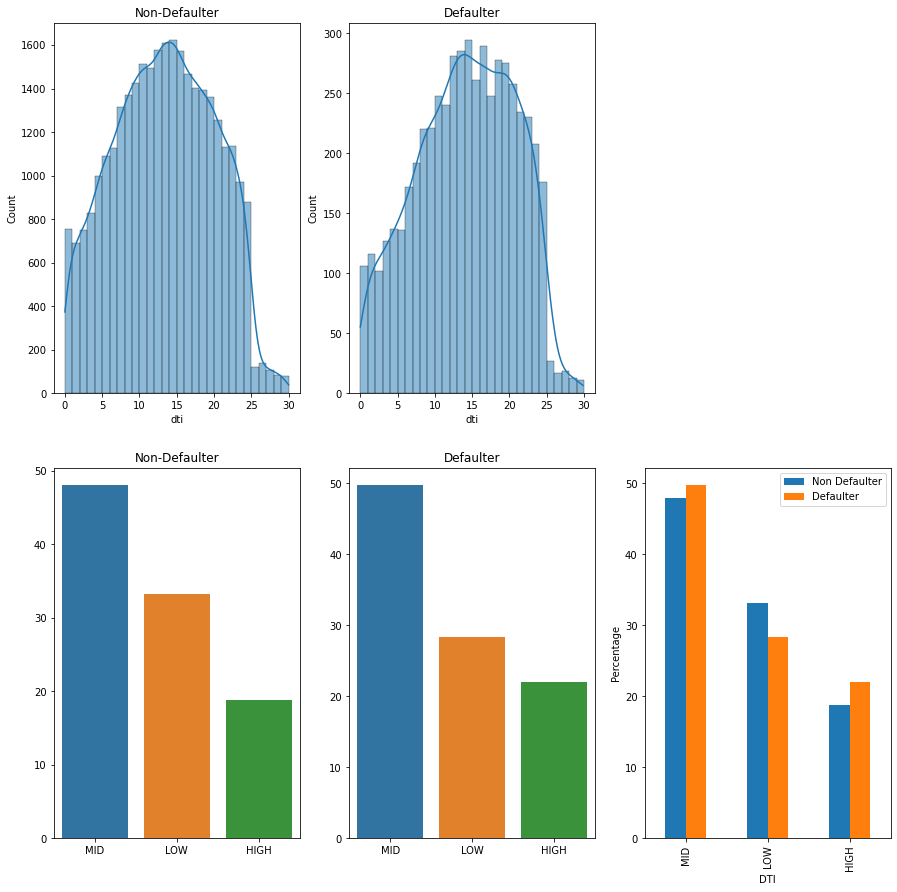

In [23]:
#Plotting dti to get insights on how this variable affects Default

fig = plt.figure()

ax = fig.add_subplot(2, 3, 1)
sns.histplot(df[df['loan_status'] == 'Non-Defaulter']['dti'], binwidth=1, kde=True, ax=ax).set_title('Non-Defaulter')
ax = fig.add_subplot(2, 3, 2)
sns.histplot(df[df['loan_status'] == 'Defaulter']['dti'], binwidth=1, kde=True, ax=ax).set_title('Defaulter')

d1 = (df[df['loan_status'] == 'Non-Defaulter']['dti_categorized'].value_counts(normalize=True)*100).to_dict()
d2 = (df[df['loan_status'] == 'Defaulter']['dti_categorized'].value_counts(normalize=True)*100).to_dict()

df_plot = pd.DataFrame.from_dict(d1, orient='index')
df_plot[1] = df_plot.index.map(d2)
df_plot['label'] = df_plot.index
df_plot.rename(columns={0:'Non Defaulter', 1:'Defaulter'}, inplace =True)

ax = fig.add_subplot(2, 3, 4)
sns.barplot(x=list(d1.keys()), y=list(d1.values()), ax=ax).set_title('Non-Defaulter')
ax = fig.add_subplot(2, 3, 5)
sns.barplot(x=list(d2.keys()), y=list(d2.values()), ax=ax).set_title('Defaulter')
ax = fig.add_subplot(2, 3, 6)
df_plot.plot(x='label', y=['Non Defaulter', 'Defaulter'], kind="bar",figsize=(15,15), ax=ax)
ax.set(xlabel='DTI', ylabel='Percentage')

#plt.savefig('DTI.png')

#People with low dti are less likely to default

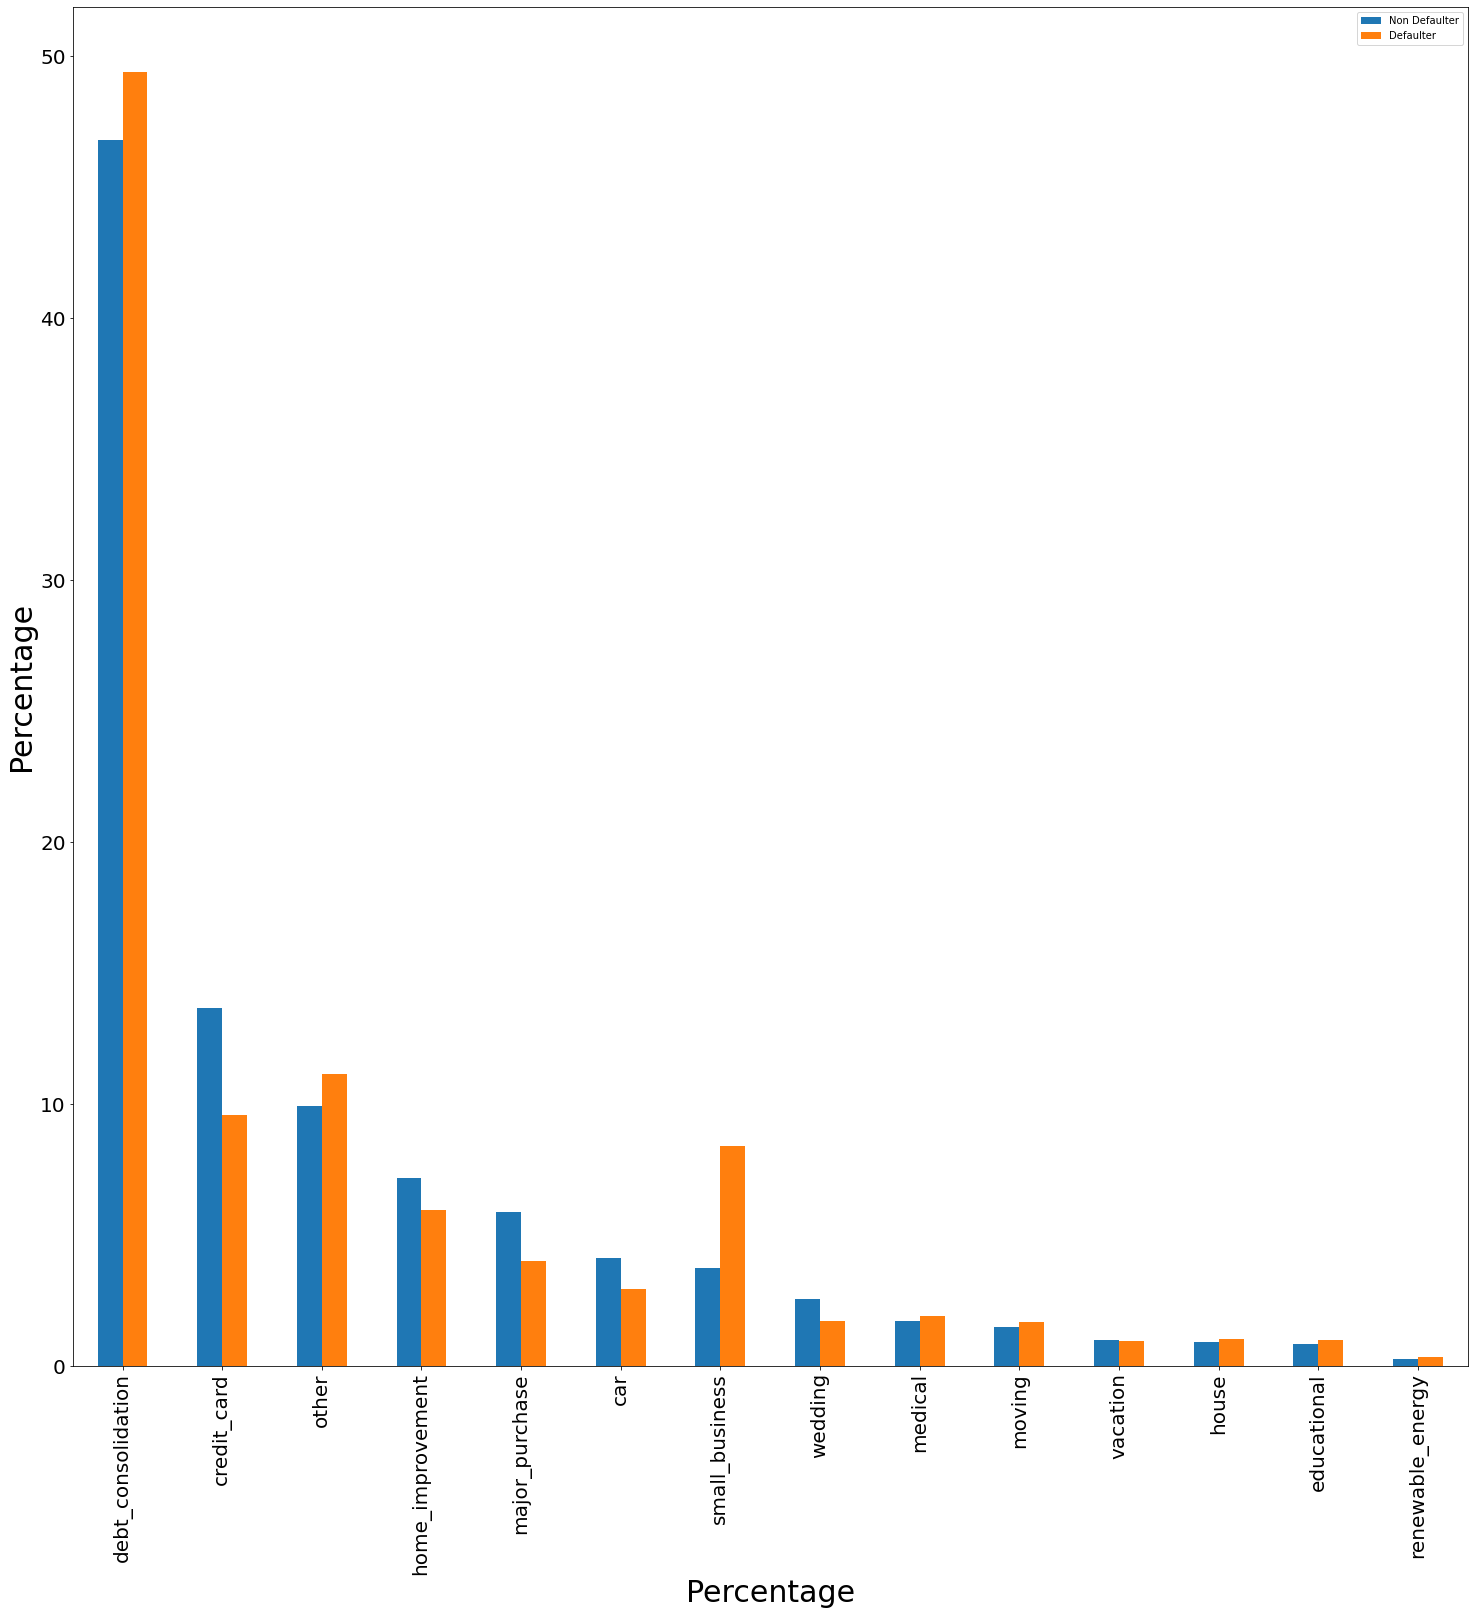

In [24]:
#Plotting purpose to get insights on how this variable affects Default

d1 = (df[df['loan_status'] == 'Non-Defaulter']['purpose'].value_counts(normalize=True)*100).to_dict()
d2 = (df[df['loan_status'] == 'Defaulter']['purpose'].value_counts(normalize=True)*100).to_dict()

df_plot = pd.DataFrame.from_dict(d1, orient='index')
df_plot[1] = df_plot.index.map(d2)
df_plot['label'] = df_plot.index
df_plot.rename(columns={0:'Non Defaulter', 1:'Defaulter'}, inplace =True)

# fig = plt.figure()

# ax = fig.add_subplot(2, 2, 1)
# sns.barplot(x=list(d1.keys()), y=list(d1.values()), ax=ax).set_title('Non-Defaulter')
# ax = fig.add_subplot(2, 2, 2)
# sns.barplot(x=list(d2.keys()), y=list(d2.values()), ax=ax).set_title('Defaulter')
# ax = fig.add_subplot(2, 2, 3)
ax = df_plot.plot(x='label', y=['Non Defaulter', 'Defaulter'], kind="bar",figsize=(25,25))
plt.xlabel('Percentage',size=30)
plt.ylabel('Percentage',size=30)
ax.tick_params(labelsize=20)

#plt.savefig('Purpose.png')

#Here we can make some interesting observations. Few purposes have a higher chances of default rate than others

### Part 4: Bivariate Analysis and Plotting

In [25]:
#Since we did not find any useful insights from few columns in univariate analysis, we drop those columns
df.drop(['open_acc', 'pub_rec', 'total_acc', 'addr_state'], axis=1, inplace=True)

In [26]:
#After plotting and checking multiple variables together with catplots and pairplots, we found that the following variables were dependent/correlated to a certain degree

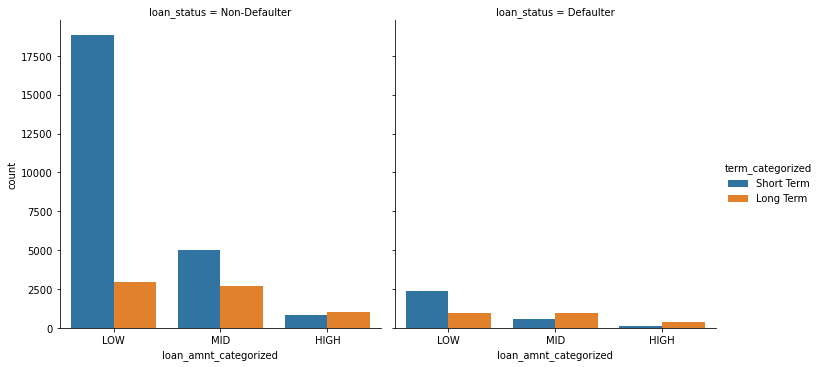

In [27]:
sns.catplot(col='loan_status', x='loan_amnt_categorized', hue='term_categorized', data= df, kind='count')

#plt.savefig('Loan Amount, Bi.png')

#There is a good observation here for the mid-range loan amount. For mid range loan amount, the customer is more likey to default for a longer term(60 months) as opposed to shorter term(36 months)

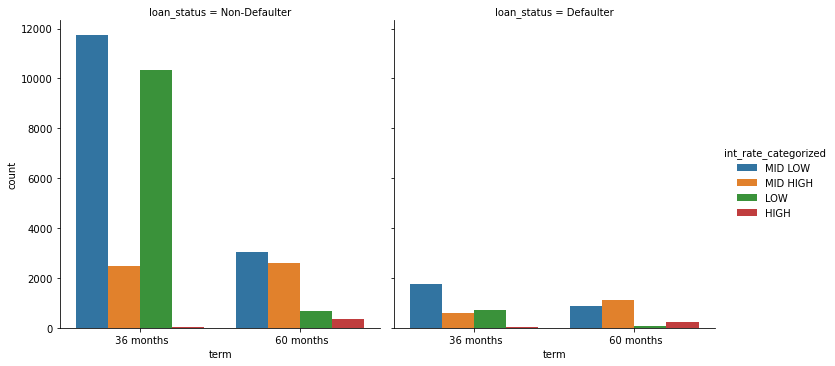

In [28]:
sns.catplot(col='loan_status', x='term', hue='int_rate_categorized', data= df, kind='count')

#plt.savefig('Term, Bi.png')

#Here we can see that for a longer term(60 months), if the interest rate is higher(MID HIGH to HIGH), the chances of default goes up

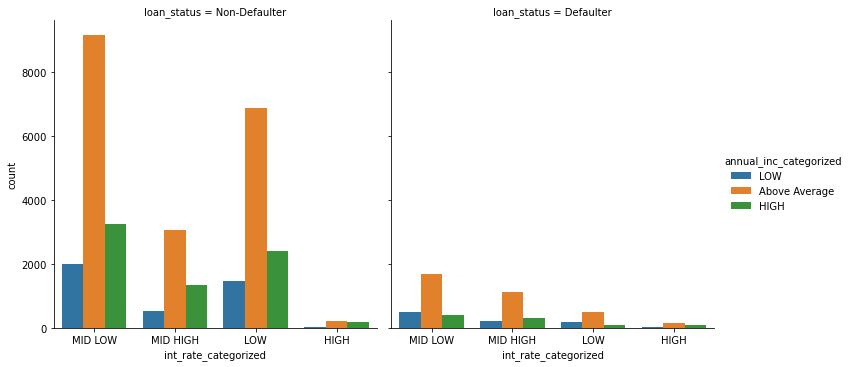

In [29]:
sns.catplot(col='loan_status', x='int_rate_categorized', hue='annual_inc_categorized', data= df, kind='count')

#plt.savefig('Interest Rate, Bi.png')

#People with high income are less likely to default if the interest rate is low. For Above average income and Low income, the chances of default remains the same

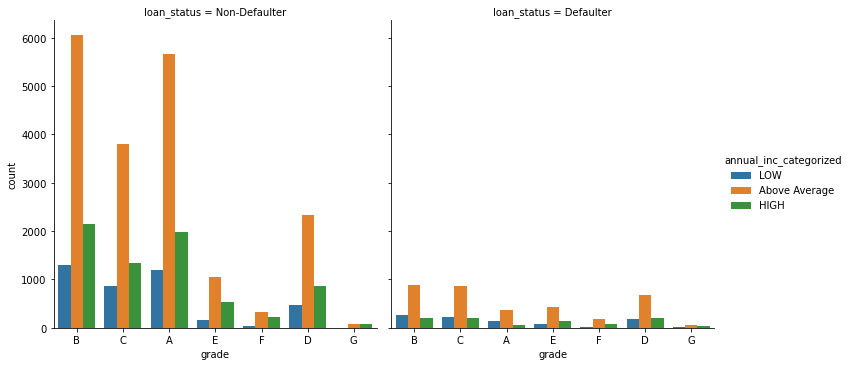

In [30]:
sns.catplot(col='loan_status', x='grade', hue='annual_inc_categorized', data= df, kind='count')

#plt.savefig('Grade, Bi.png')

#We can see that the likely hood to default drastically decreases for high income customers when grade is A,B,C. For the rest, there is little to no change

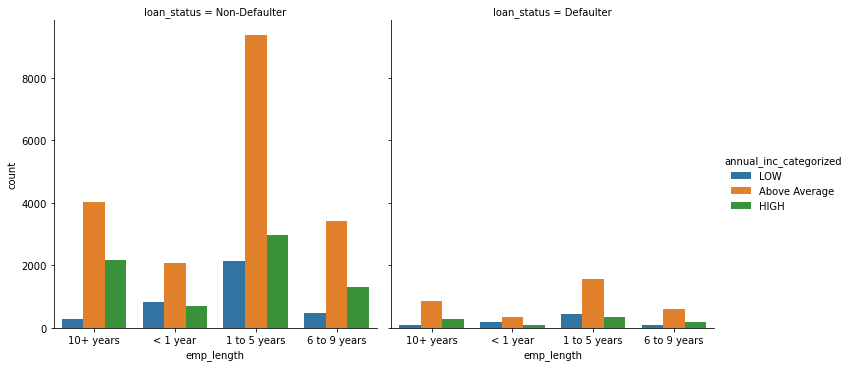

In [31]:
sns.catplot(col='loan_status', x='emp_length', hue='annual_inc_categorized', data= df, kind='count')

#plt.savefig('Annual Income, Bi.png')

#People with employment time of 1 to 5 years with a high annual income are less likey to default. The rest are fairly independent on annual income

### Part 5: Conclusions

**We will split the variable into** 
-Customer Factors -- Employment Length, Annual Income, Verification Status
-Loan Factors -- Loan Amount, Interest Rate, Term, Loan Status, Grade

------------------------------------------------------------------------------------------------------------

**Strictly Based on Univariate Analysis, we can Draw the following Conclusions**
As the loan amount increases, the likelihood of default increases
For low income, the likely hood of default is very high, but for Above average income, the likelihood of default is slightly lower and for high income, the likelihood of default is significantly lower
As the time(term) increases, the likelihood of default increases
People who have been employed for less than 10 years are less likely to default that those who have been employed for over 10 years
As the grade goes up, the likely hood of default increases greately.
Income sources that are not verified are less likely to default. The fact that the default rate of Verified income is higher could be due to faulty verification as the source verified does not have a significant default rate
As the interest rate increases, the chances of default increase dramatically.
People with low DTI are less likely to default.

------------------------------------------------------------------------------------------------------------

**Strictly Based on Bivariate Analysis, we can Draw the following Conclusions**

When an application is made, we need to look at the Loan amount, Interest Rate, Term and Grade.
We know that for a longer term(60 months) loan, if the interest rate is higher(MID HIGH to HIGH), the chances of default goes up. Therefore providing short term loans for a higher amount.

When a high interest loan is to be given out, we can take a look at how it is depended on Annual Income
People with high income are less likely to default if the interest rate is low. For Above average income and Low income, the chances of default remains the same.
We can make the same type of argument for Grade, but if we take a closer look, the grade is highly correlated with interest rate. This would mean that a higher grade like G has higher interest rate.

Also looking at the customer details.
People with employment time of 1 to 5 years with a high annual income are less likey to default. The rest are fairly independent on annual income. It would be a safer bet to pick these customers.

------------------------------------------------------------------------------------------------------------